# Pangenome taxonomy link prediction

## Setup

In [1]:
## Notebook config
import sys
if '../' not in sys.path:
    sys.path.append("../")
%load_ext dotenv
%reload_ext dotenv
%dotenv

# Notebook imports
import ast
import gc
import os
import pickle

from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx
from sklearn.metrics import (
    average_precision_score,
    roc_auc_score,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
)

In [2]:
DATASET_DIR = './dataset/'
EVALS_DIR = './evals/'

RANDOM_SEED = 42

## Neo4j GDS Link prediction pipeline

In [3]:
from graphdatascience import GraphDataScience

ModuleNotFoundError: No module named 'graphdatascience'

In [ ]:
PROJECTION_NAME_PREFIX = 'ml_projection_'

NEO4J_URI = os.environ.get('NEO4J_URI')
NEO4J_USER = os.environ.get('NEO4J_USER')
NEO4J_PASSWORD = os.environ.get('NEO4J_PASSWORD')

TEST_FRACTION = 0.3
TRAIN_FRACTION = 0.6
MIN_EPOCHS = 10
MAX_EPOCHS = 100
VALIDATION_FOLDS = 5  # used to tune hyperparameters and determine best model
NEGATIVE_SAMPLING_RATIO = 1 # (q - r) / r, where q = n(n-1)/2, n = number of nodes, r = actual number of edges
NEGATIVE_CLASS_WEIGHT = 1# / NEGATIVE_SAMPLING_RATIO

### Projection

In [ ]:
def get_gds_client():
    return GraphDataScience(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))

def get_projection_name(version=1):
    return PROJECTION_NAME_PREFIX + str(version)


def get_projection(gds, projection_name, for_predictions=False):
    if gds.graph.exists(projection_name)['exists']:
        return gds.graph.get(projection_name)
    
    pangenome_nodes = pd.read_csv(DATASET_DIR + 'pangenome_nodes.csv')
    taxon_nodes = pd.read_csv(DATASET_DIR + 'taxon_nodes.csv')

    # prune taxonomy tree to only include viruses
    taxon_nodes = taxon_nodes.loc[
        taxon_nodes['taxKingdom'] == 'Viruses'
    ]
    taxon_nodes['nodeLabels'] = [
        ['Taxon', 'TargetRank'] 
        if x == 'order' 
        else 'Taxon' 
        for x in taxon_nodes['rank']
    ]

    # assert there's no collision of nodeIds from diffferent DB instances
    assert len(set(pangenome_nodes['nodeId'].values).intersection(set(taxon_nodes['nodeId'].values))) == 0

    nodes = pd.concat([pangenome_nodes, taxon_nodes])
    nodes['labels'] = nodes['nodeLabels']
    # prune segmeneted fasta nodes
    nodes = nodes.loc[
        (nodes['labels'] != 'Fasta') |
        (nodes['isSegmented'] == False)
    ]
    nodes = nodes[[
        'nodeId',
        'labels',
        'degree',
    ]]

    pangenome_rels = pd.read_csv(DATASET_DIR + 'pangenome_edges.csv')
    taxonomy_rels = pd.read_csv(DATASET_DIR + 'taxon_has_parent_edges.csv')
    taxonomy_rels = taxonomy_rels.loc[
        taxonomy_rels['sourceNodeId'].isin(taxon_nodes['nodeId'].values) &
        taxonomy_rels['targetNodeId'].isin(taxon_nodes['nodeId'].values)
    ]

    pangenome_taxonomy_rels = pd.read_csv(DATASET_DIR + 'fasta_has_tax_order_edges.csv')
    relationships = pd.concat([
        pangenome_rels,
        taxonomy_rels,
        pangenome_taxonomy_rels,
    ])

    relationships = relationships[[
        'sourceNodeId',
        'targetNodeId',
        'relationshipType',
        'weight'
    ]]

    undirected_relationship_types = relationships['relationshipType'].unique().tolist()
    if not for_predictions:
        # undirected_relationship_types.remove('hasTaxOrder')
        undirected_relationship_types.remove('hasHit')
        undirected_relationship_types.remove('hasRegion')
        # undirected_relationship_types.remove('hasAffiliate')
        undirected_relationship_types.remove('hasDownstream')
        # undirected_relationship_types.remove('hasMember')
        
    projection = gds.graph.construct(
        graph_name=projection_name,
        nodes=nodes,
        relationships=relationships,
        concurrency=4,
        undirected_relationship_types=undirected_relationship_types,
    )
    return projection

def delete_projection(gds, projection_name):
    if gds.graph.exists(projection_name)['exists']:
        gds.graph.drop(gds.graph.get(projection_name))


In [ ]:
version = 1
projection_name = get_projection_name(version)
gds = get_gds_client()
delete_projection(gds, projection_name)
projection = get_projection(gds, projection_name)
print(projection)

### GraphSage test

- GraphSage cannot be trained in the GDS pipeline, and it doesn't seem to be possible to get the test split from the gds pipeline.
- To avoid info leakeage, we'd need to create a seperate dataset to train graphsage.
- We can also consider resampling the dataset to balance each of the taxonomy orders with varying number of hits to produce better embeddings.
- Running graphSage on the current neo4j instance causes it to crash, will try this pipeline in pytorch on a high-memory instance later

In [ ]:
response = gds.alpha.ml.splitRelationships.mutate(
    G=gds.graph.get(projection_name),
    sourceNodeLabels=['Fasta'],
    targetNodeLabels=['TargetRank'],
    relationshipTypes=['hasTaxOrder'],
    holdoutFraction=TEST_FRACTION,
    randomSeed=RANDOM_SEED,
    holdoutRelationshipType='hasTaxOrder_TEST',
    remainingRelationshipType='hasTaxOrder_TRAIN',
    negativeSamplingRatio=NEGATIVE_SAMPLING_RATIO,
    relationshipWeightProperty='weight',
)

In [ ]:
# Preprocessing

gds.fastRP.mutate(
    G=gds.graph.get(projection_name),
    mutateProperty='fastRP',
    randomSeed=RANDOM_SEED,
    # relationshipWeightProperty='weight',
    # featureProperties=["degree"],
    nodeLabels=[
        'Taxon',
        'Fasta',
        'Hit',
        'HitFamily',
        'HitRegion',
    ],
    relationshipTypes=[
        # "*",
        'hasTaxOrder_TRAIN',
        'HAS_PARENT',
        'hasHit',
        'hasRegion',
        'hasAffiliate',
        'hasMember',
        'hasDownstream',
    ],
    embeddingDimension=128,
    normalizationStrength=-0.5,
    # nodeSelfInfluence=2,
)

In [ ]:
if gds.beta.model.exists('graphSage')['exists']:
    gds.beta.model.drop(gds.model.get('graphSage'))

gds.beta.graphSage.train(
    G=gds.graph.get(projection_name),
    modelName='graphSage',
    featureProperties=['fastRP'],
    nodeLabels=[
        'Taxon',
        'Fasta',
        'Hit',
        'HitFamily',
        'HitRegion',
    ],
    relationshipTypes=[
        # '*'
        'hasTaxOrder_TEST',
        'HAS_PARENT',
        'hasHit',
        'hasRegion',
        'hasAffiliate',
        'hasMember',
        'hasDownstream',
    ],
    embeddingDimension=256,
    epochs=10,
    searchDepth=10,
    # relationshipWeightProperty='weight',
    # featureProperties=['fastRP', 'degree'],
    # featureProperties=['degree'],
    # featureProperties=[],
)

In [ ]:
# graph_sage_embeddings = gds.beta.graphSage.stream(
#     G=gds.graph.get(projection_name),
#     modelName='graphSage',
#     nodeLabels=[
#         'Taxon',
#         'Fasta',
#         'Hit',
#         'HitFamily',
#         'HitRegion',
#     ],
#     relationshipTypes=['*'],
# )

### Train-eval pipeline

In [ ]:
# Configure pipeline

pipeline_name = 'taxon_lp_pipeline'
model_encoder = 'fastRP'

if gds.beta.pipeline.exists(pipeline_name)['exists']:
    gds.beta.pipeline.drop(gds.pipeline.get(pipeline_name))

pipeline, _ = gds.beta.pipeline.linkPrediction.create(pipeline_name)

G = gds.graph.get(projection_name)

pipeline.addNodeProperty(
    procedure_name=model_encoder,
    mutateProperty=model_encoder,
    embeddingDimension=384, # 384
    randomSeed=RANDOM_SEED,
    # featureProperties=["features"],
    relationshipWeightProperty='weight',
    normalizationStrength=-0.5,
    # nodeSelfInfluence=2,
    contextRelationshipTypes=[
        "HAS_PARENT",
        "hasHit",
        "hasRegion",
        "hasAffiliate",
        "hasMember",
        "hasDownstream",
    ],
    contextNodeLabels=[
        "Taxon",
        "Fasta",
        "Hit",
        "HitRegion",
        "HitFamily",
    ],
)

# L2, HADAMARD, COSINE, SAME_CATEGORY
pipeline.addFeature("hadamard", nodeProperties=[model_encoder])

# pipeline.addNodeProperty(
#     procedure_name="beta.graphSage",
#     mutateProperty="graphSage",
#     modelName="graphSage",
#     # featureProperties=["fastRP"],
#     contextRelationshipTypes=[
#         "HAS_PARENT",
#         "hasHit",
#         "hasRegion",
#         "hasAffiliate",
#         "hasMember",
#         "hasDownstream",
#     ],
#     contextNodeLabels=[
#         "Taxon",
#         "Fasta",
#         "Hit",
#         "HitRegion",
#         "HitFamily",
#     ],
#     # relationshipWeightProperty="weight",
# )

# pipeline.addFeature("hadamard", nodeProperties=["graphSage"])

split = pipeline.configureSplit(
    testFraction=TEST_FRACTION,
    validationFolds=VALIDATION_FOLDS,
    negativeSamplingRatio=NEGATIVE_SAMPLING_RATIO,
)

pipeline.addLogisticRegression(penalty=(0.1, 2))
# pipeline.addLogisticRegression(maxEpochs=200, penalty=(0.0, 2))
pipeline.addRandomForest(maxDepth=(2, 50))
# pipeline.addRandomForest(maxDepth=(2, 100))

# Last layer should match number of classes being predicted
# pipeline.addMLP(hiddenLayerSizes=[16, 16, 4], penalty=1, patience=2)
# pipeline.addMLP(hiddenLayerSizes=[128, 64, 2], maxEpochs=100, patience=10)
# [128, 256, 128, 2]
# [256, 128, 2] *
# [256, 384, 256, 128, 2]
pipeline.addMLP(
    # hiddenLayerSizes=[256, 128, 2], #[384, 128, 2],
    hiddenLayerSizes=[384, 128, 2],
    maxEpochs=100,
    patience=10,
    focusWeight=0.5,
    # focusWeight={'range': [0.0, 0.5]},
)

In [ ]:
# Run the train and eval pipeline

if gds.beta.model.exists(model_encoder)['exists']:
    gds.beta.model.drop(gds.model.get(model_encoder))

model, evals = pipeline.train(
    pipeline=pipeline,
    G=gds.graph.get(projection_name),
    modelName=model_encoder,
    randomSeed=RANDOM_SEED,
    targetRelationshipType='hasTaxOrder',
    sourceNodeLabel='Fasta',
    targetNodeLabel='TargetRank',
    negativeClassWeight=NEGATIVE_CLASS_WEIGHT,
    metrics=[ 
        'AUCPR'
    ],
)

evals.to_csv(EVALS_DIR + 'lp_gds_evals.csv')
display(evals['modelInfo']['bestParameters'])

print('-----------------')

print('Best model metrics (general):')
print('AUCPR:')
display(evals['modelInfo']['metrics']['AUCPR'])

# {'test': 0.8079789288270317,
#  'validation': {'min': 0.7552969944662513,
#   'max': 0.7978044070290363,
#   'avg': 0.7801199361717549},
#  'outerTrain': 0.99993761244742,
#  'train': {'min': 0.9999357007540141,
#   'max': 0.9999999999999999,
#   'avg': 0.999974082447445}}

# {'test': 0.7165068713762617,
#  'validation': {'min': 0.6341140732932966,
#   'max': 0.7483135387115906,
#   'avg': 0.6846875847262417},
#  'outerTrain': 0.9999455163442132,
#  'train': {'min': 0.9999510657293991,
#   'max': 0.9999836847323984,
#   'avg': 0.9999713434218448}}

# {'test': 0.9886814718381982,
#  'validation': {'min': 0.985947330770067,
#   'max': 0.9909918266054518,
#   'avg': 0.9887788612948111},
#  'outerTrain': 0.9989832669230688,
#  'train': {'min': 0.9989039358314438,
#   'max': 0.998947612674645,
#   'avg': 0.9989210279491374}}

### Predictions

In [ ]:
version = 1

projection_name = get_projection_name(version)
gds = get_gds_client()
delete_projection(gds, projection_name)
projection = get_projection(gds, projection_name, for_predictions=True)
print(projection)

In [ ]:
# map nodeIds to appIds

def enrich_app_data(df):
    pangenome_nodes = pd.read_csv(DATASET_DIR + 'pangenome_nodes.csv')
    fasta_nodes = pangenome_nodes.loc[
        pangenome_nodes['nodeLabels'] == 'Fasta'
    ]
    fasta_nodes = fasta_nodes[[
        'nodeId',
        'appId',
        'order',
    ]]
    taxon_nodes = pd.read_csv(DATASET_DIR + 'taxon_nodes.csv')
    taxon_nodes = taxon_nodes.loc[
        taxon_nodes['taxKingdom'] == 'Viruses'
    ]
    taxon_nodes = taxon_nodes[[
        'nodeId',
        'appId',
        'taxOrder',
        'rank',
    ]]

    df = pd.merge(
        df,
        fasta_nodes,
        how='left',
        left_on='sourceNodeId',
        right_on='nodeId',
    )
    df.drop('nodeId', axis=1, inplace=True)
    df.rename(columns={'appId': 'sourceAppId', 'order': 'expectedOrder'}, inplace=True)

    df = pd.merge(
        df,
        taxon_nodes,
        how='left',
        left_on='targetNodeId',
        right_on='nodeId',
    )
    df.drop('nodeId', axis=1, inplace=True)
    df.rename(columns={'appId': 'targetAppId', 'taxOrder': 'predictedOrder', 'rank': 'predictedRank'}, inplace=True)

    return df



def format_predictions(predictions):
    predictions = predictions.sort_values(['node1', 'probability'], ascending=[True, False])
    predictions['sourceNodeId'] = predictions['node1']
    predictions.drop('node1', axis=1, inplace=True)
    predictions['targetNodeId'] = predictions['node2']
    predictions.drop('node2', axis=1, inplace=True)

    merged = enrich_app_data(predictions)
    # merged.dropna(inplace=True)

    if merged['sourceAppId'].isna().sum() > 0:
        non_null = merged.loc[
            ~merged['sourceAppId'].isna()
        ]
        reversed_direction = merged.loc[
            merged['sourceAppId'].isna()
        ]
        reversed_direction[['sourceNodeId','targetNodeId']] = reversed_direction[['targetNodeId','sourceNodeId']]
        reversed_direction.drop([
                'sourceAppId',
                'targetAppId',
                'expectedOrder',
                'predictedOrder',
                'predictedRank'
            ], axis=1, inplace=True)
        reversed_direction = enrich_app_data(reversed_direction)
        merged = pd.concat([non_null, reversed_direction])

    merged['correct'] = merged['expectedOrder'] == merged['predictedOrder']
    return merged

In [ ]:
def stream_exhaustive_predictions(model):
    # Stream approximate predictions
    predictions = model.predict_stream(
        G=gds.graph.get(projection_name),
        # topK=1,
        topN=6318,
        # randomSeed=RANDOM_SEED,
        sourceNodeLabel='Fasta',
        targetNodeLabel='TargetRank',
        relationshipTypes=[
            # "hasTaxOrder",
            "HAS_PARENT",
            "hasHit",
            "hasRegion",
            "hasAffiliate",
            "hasMember",
            "hasDownstream",
        ],
        sampleRate=1, # 1 = exhaustive
        # threshold=0.5,
        # randomJoins=2,
        # maxIterations=3,
        # deltaThreshold=0.01,
    )
    return predictions


def stream_approximate_predictions(model):
    predictions = model.predict_stream(
        G=gds.graph.get(projection_name),
        topK=1,
        # randomSeed=RANDOM_SEED,
        sourceNodeLabel='Fasta',
        targetNodeLabel='TargetRank',
        relationshipTypes=[
            # "hasTaxOrder",
            "HAS_PARENT",
            "hasHit",
            "hasRegion",
            "hasAffiliate",
            "hasMember",
            "hasDownstream",
        ],
        sampleRate=0.1, # 1 = exhaustive
        # threshold=0.5,
        # randomJoins=2,
        # maxIterations=3,
        # deltaThreshold=0.01,
    )
    return predictions

In [ ]:
# model = gds.model.get('fastRP')
# preds_raw = stream_exhaustive_predictions(model)
preds_raw = stream_approximate_predictions(model)
preds = format_predictions(preds_raw)
print(preds)

In [ ]:
preds.to_csv(DATASET_DIR + 'lp_gds_preds.csv', index=False)

In [ ]:
print(preds['sourceAppId'].isna().sum())

In [ ]:
print(preds['probability'].describe())
print(preds_raw['node1'].nunique())
print(preds['sourceNodeId'].nunique())
print(len(preds))

In [ ]:
print(preds['correct'].value_counts())
# correct
# False    61282
# True      1038

# group by source and check if any targets are correct
grouped = preds.groupby('sourceAppId')
grouped_correct = grouped['correct'].any()
print(grouped_correct.value_counts())

# correct
# False    5372
# True      788

# False    5264
# True      968

# False    5194
# True     1038


In [ ]:
gds.graph.drop(get_projection_name())
gds.beta.model.drop(gds.model.get(model_encoder))
gds.beta.pipeline.drop(gds.pipeline.get(pipeline_name))

## Pytorch Geometric

In [3]:
# Set cuda device before imports

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"


In [4]:
import torch
from torch_geometric import seed_everything
from torch_geometric.data import HeteroData
from torch_geometric.loader import LinkNeighborLoader
from torch_geometric.utils import to_networkx, degree, mask_select
from torch_geometric.nn import SAGEConv, GATConv, GCNConv, to_hetero, MIPSKNNIndex, BatchNorm
import torch_geometric.transforms as T
import torch.nn.functional as F
from torch_geometric.metrics import (
    LinkPredMAP,
    LinkPredPrecision,
    LinkPredRecall,
)
import umap

/home/rnalab/ljp/.conda/envs/ljp/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [32]:
# Global config vars
MODEL_DIR = './models/'

NEGATIVE_SAMPLING_RATIO = 1
TEST_FRACTION = 0
VAL_FRACTION = 0
TRAIN_FRACTION = 1 - TEST_FRACTION - VAL_FRACTION
MAX_EPOCHS = 100
MIN_EPOCHS = 5
BATCH_SIZE = 1024 # 1024, 2048, 4096
NUM_NEIGHBORS = [-1, -1, 10, 10] # [-1, -1, -1, -1]

COLLAPSE_TAXONOMY_GRAPH = True
COLLAPSE_PANGENOME_GRAPH = True
ADD_METAPATHS = False
INCLUDE_HAS_HOST = False
USE_ESM_EMBEDDINGS = False
USE_LLM_EMBEDDINGS = False

RESAMPLED_DATASET = False

seed_everything(RANDOM_SEED)

# device  = torch.device('cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [33]:
print(torch.cuda.is_available())
print(torch.cuda.current_device())

def clear_cuda_mem():
    torch.cuda.empty_cache()
    gc.collect()

True
0


In [34]:
# Dataframe encoders 

class IdentityEncoder(object):
    # The 'IdentityEncoder' takes the raw column values and converts them to
    # PyTorch tensors.
    def __init__(self, dtype=None, is_list=False, is_tensor=False):
        self.dtype = dtype
        self.is_list = is_list
        self.is_tensor = is_tensor

    def __call__(self, df):
        if self.is_tensor:
            if self.is_list:
                return torch.stack([torch.tensor([el]) for el in df.values])
            return torch.from_numpy(df.values).to(self.dtype)
        else:
            return df


class ListEncoder(object):
    def __init__(self, sep=',', is_tensor=False):
        self.sep = sep
        self.is_tensor = is_tensor

    def __call__(self, df):
        eval_df = df.apply(
            lambda x: [val for val in ast.literal_eval(x)])
        return torch.stack([torch.tensor(el) for el in eval_df.values])


class LabelEncoder(object):
    # The 'LabelEncoder' splits the raw column strings by 'sep' and converts
    # individual elements to categorical labels.
    def __init__(self, sep=',', is_tensor=False, mapping=None):
        self.sep = sep
        self.is_tensor = is_tensor
        self.mapping = mapping

    def __call__(self, df):
        mapping = self.mapping
        if self.is_tensor:
            if not mapping:
                labels = set(
                    label for col in df.values
                    for label in col.split(self.sep)
                )
                mapping = {label: i for i, label in enumerate(labels)}
            x = torch.zeros(len(df), len(mapping))
            for i, col in enumerate(df.values):
                for label in col.split(self.sep):
                    x[i, mapping[label]] = 1
            return x
        if not mapping:
            labels = df[df.columns[0]].unique()
            mapping = {label: i for i, label in enumerate(labels)}
        return df.replace(mapping)


In [35]:
# Create pytorch geometric graph

def load_node_tensor(df, index_col, encoders=None):
    mapping = {index: i for i, index in enumerate(df.index.unique())}
    x = torch.ones(size=(len(df.index), 1))

    if encoders is not None:
        xs = [encoder(df[col]) for col, encoder in encoders.items()]
        x = torch.cat(xs, dim=-1)
        x = x.float()
    
    assert len(mapping) == len(df.index.unique())
    return x, mapping


def load_edge_tensor(df, src_index_col, src_mapping,
                     dst_index_col, dst_mapping, encoders=None):
    
    src = [src_mapping[index] for index in df[src_index_col]]
    dst = [dst_mapping[index] for index in df[dst_index_col]]
    edge_index = torch.tensor([src, dst])
    edge_attr = None
    if encoders is not None:
        edge_attrs = [encoder(df[col]) for col, encoder in encoders.items()]
        edge_attr = torch.cat(edge_attrs, dim=-1)

    return edge_index, edge_attr


def get_filtered_taxon_nodes():
    taxon_nodes_df = pd.read_csv(
        f'{DATASET_DIR}taxon_nodes.csv',
        index_col='appId',
        header=0,
    )
            
    ## prune taxonomy tree to only include viruses and specific known hosts
    if INCLUDE_HAS_HOST:
        fasta_has_host = pd.read_csv(
            f'{DATASET_DIR}fasta_has_host_gb_edges.csv',
            header=0
        )
        fasta_has_host['targetAppId'] = fasta_has_host['targetAppId'].astype(int)
        taxon_nodes_df = taxon_nodes_df.loc[
            (taxon_nodes_df['taxKingdom'] == 'Viruses') | 
            (taxon_nodes_df['taxId'].isin(fasta_has_host['targetAppId']))
        ]
    else:
        taxon_nodes_df = taxon_nodes_df.loc[
            taxon_nodes_df['taxKingdom'] == 'Viruses'
        ]
    
    return taxon_nodes_df


def get_filtered_pangenome_nodes():
    pangenome_nodes_df = pd.read_csv(
        f'{DATASET_DIR}pangenome_nodes.csv',
        index_col='appId',
        header=0,
    )
    ## prune segmeneted fasta nodes
    pangenome_nodes_df = pangenome_nodes_df.loc[
        (pangenome_nodes_df['nodeLabels'] != 'Fasta') |
        (pangenome_nodes_df['isSegmented'] == False)
    ]

    if RESAMPLED_DATASET:
        resampled_fastas = pd.read_csv(
            f'{DATASET_DIR}fasta_resampled_family.csv',
        )
        pangenome_nodes_df = pangenome_nodes_df.loc[
            (pangenome_nodes_df['nodeLabels'] != 'Fasta') |
            (pangenome_nodes_df['accession'].isin(resampled_fastas['accession']))
        ]
        filtered_names = tuple(resampled_fastas['name'].values)
        pangenome_nodes_df = pangenome_nodes_df.loc[
            (pangenome_nodes_df['nodeLabels'] != 'Hit') |
            (~pangenome_nodes_df['name'].str.startswith(filtered_names))
        ]
        pangenome_nodes_df = pangenome_nodes_df.loc[
            (pangenome_nodes_df['nodeLabels'] != 'HitRegion') |
            (~pangenome_nodes_df['name'].str.startswith(filtered_names))
        ]

    return pangenome_nodes_df


def create_pyg_graph():
    data = HeteroData()
    mappings = {}

    ## Load taxons node tensors
    taxon_nodes_df = get_filtered_taxon_nodes()
    target_taxons = taxon_nodes_df.loc[
        taxon_nodes_df['rank'] == 'order'
    ]
    target_taxon_x, target_taxon_mapping = load_node_tensor(
        df=target_taxons,
        index_col='appId',
        # encoders={
        #     'fastrp': ListEncoder(is_tensor=True),
        # }
    )
    data['TargetTaxon'].node_id = torch.arange(len(target_taxon_mapping))
    # data['TargetTaxon'].x = target_taxon_x
    mappings['TargetTaxon'] = target_taxon_mapping

    ## Load pangenome node tensors 
    pangenome_nodes_df = get_filtered_pangenome_nodes()

    for node_type in ['Fasta', 'Hit', 'HitRegion', 'HitFamily']:
        node_df = pangenome_nodes_df.loc[
            pangenome_nodes_df['nodeLabels'] == node_type
        ]
        x, mapping = load_node_tensor(
            df=node_df,
            index_col='appId',
        )
        data[node_type].node_id = torch.arange(len(mapping))
        # data[node_type].x = x
        mappings[node_type] = mapping

    ## Load pangenome edge tensors
    pangenome_edges_df = pd.read_csv(
        f'{DATASET_DIR}pangenome_edges.csv',
        header=0
    )
    # remove edges that are not in the pruned pangenome graph
    pangenome_edges_df = pangenome_edges_df.loc[
        pangenome_edges_df['sourceAppId'].isin(pangenome_nodes_df.index) &
        pangenome_edges_df['targetAppId'].isin(pangenome_nodes_df.index)
    ]
    config = {
        'hasMember': {
            'src': 'HitFamily',
            'dst': 'Hit',
        },
        'hasHit': {
            'src': 'Fasta',
            'dst': 'Hit',
        },
        'hasRegion': {
            'src': 'Fasta',
            'dst': 'HitRegion',
        },
        'hasAffiliate': {
            'src': 'HitRegion',
            'dst': 'Hit',
        },
        'hasDownstream': {
            'src': 'HitRegion',
            'dst': 'HitRegion',
        },
    }
    for rel_type, rel_config in config.items():
        edge_df = pangenome_edges_df.loc[
            pangenome_edges_df['relationshipType'] == rel_type
        ]
        edge_index, edge_label = load_edge_tensor(
            df=edge_df,
            src_index_col='sourceAppId',
            src_mapping=mappings[rel_config['src']],
            dst_index_col='targetAppId',
            dst_mapping=mappings[rel_config['dst']],
            encoders={
                'weight': IdentityEncoder(dtype=torch.float, is_tensor=True)
            },
        )
        data[rel_config['src'], rel_type, rel_config['dst']].edge_index = edge_index
        data[rel_config['src'], rel_type, rel_config['dst']].edge_label = edge_label


    ## Load pangenome taxon edge tensors
    pangenome_taxon_edges_df = pd.read_csv(
        f'{DATASET_DIR}fasta_has_tax_order_edges.csv',
        header=0
    )
    ## remove edges that are not in the pruned pangenome graph or taxon tree
    pangenome_taxon_edges_df = pangenome_taxon_edges_df.loc[
        pangenome_taxon_edges_df['sourceAppId'].isin(pangenome_nodes_df.index) &
        pangenome_taxon_edges_df['targetAppId'].isin(taxon_nodes_df.index)
    ]
    edge_index, edge_label = load_edge_tensor(
        df=pangenome_taxon_edges_df,
        src_index_col='sourceAppId',
        src_mapping=mappings['Fasta'],
        dst_index_col='targetAppId',
        dst_mapping=mappings['TargetTaxon'],
    )
    data['Fasta', 'hasTaxOrder', 'TargetTaxon'].edge_index = edge_index
    data['Fasta', 'hasTaxOrder', 'TargetTaxon'].edge_label = edge_label
    
    # delete fasta nodes with missing taxon edges
    # for node_id in data['Fasta'].node_id:
    #     if node_id not in edge_label_index[0]:


    # transform = T.Compose([T.remove_isolated_nodes.RemoveIsolatedNodes()])
    # data = transform(data)

    return data, mappings


data, mappings = create_pyg_graph()

In [36]:
# Add contextual nodes and edges to test/train graphs

def add_context_taxonomy_collapsed(data, mappings):
    taxon_nodes_df = get_filtered_taxon_nodes()
    target_taxons = taxon_nodes_df.loc[
        taxon_nodes_df['rank'] == 'order'
    ]
    # Lefavirales (Taxonomy ID: 2840070) has no order
    target_taxons = target_taxons.loc[
        ~target_taxons['taxPhylum'].isna()
    ]
    context_taxons = taxon_nodes_df.loc[
        taxon_nodes_df['rank'].isin(['phylum', 'kingdom'])
    ]
    context_taxon_x, context_taxon_mapping = load_node_tensor(
        df=context_taxons,
        index_col='appId',
        # encoders={
        #     'fastrp': ListEncoder(is_tensor=True),
        # }
    )
    data['ContextTaxon'].node_id = torch.arange(len(context_taxon_mapping))
    # data['ContextTaxon'].x = context_taxon_x
    mappings['ContextTaxon'] = context_taxon_mapping

    order_to_phylum_edges = []
    phylum_to_kingdom_edges = []
    for _, target_taxon in target_taxons.iterrows():
        # if target_taxon['taxPhylum'].isna() :
        #     print(target_taxon['taxId'])
        #     continue

        phylum_tax_id = taxon_nodes_df.loc[
            (taxon_nodes_df['taxPhylum'] == target_taxon['taxPhylum']) &
            (taxon_nodes_df['rank'] == 'phylum')
        ]['taxId'].values[0]
        
        kingdom_tax_id = taxon_nodes_df.loc[
            (taxon_nodes_df['taxKingdom'] == target_taxon['taxKingdom']) &
            (taxon_nodes_df['rank'] == 'kingdom')
        ]['taxId'].values[0]

        order_to_phylum_edges.append({
            'sourceAppId': target_taxon['taxId'],
            'targetAppId': phylum_tax_id,
            'weight': 1
        })

        phylum_to_kingdom_edges.append({
            'sourceAppId': phylum_tax_id,
            'targetAppId': kingdom_tax_id,
            'weight': 1,
        })

    order_to_phylum_edges = pd.DataFrame(order_to_phylum_edges).drop_duplicates()
    phylum_to_kingdom_edges = pd.DataFrame(phylum_to_kingdom_edges).drop_duplicates()

    edge_index, edge_label = load_edge_tensor(
        df=order_to_phylum_edges,
        src_index_col='sourceAppId',
        src_mapping=mappings['TargetTaxon'],
        dst_index_col='targetAppId',
        dst_mapping=mappings['ContextTaxon'],
        encoders={
            'weight': IdentityEncoder(dtype=torch.float, is_tensor=True)
        },
    )
    data['TargetTaxon', 'hasParent', 'ContextTaxon'].edge_index = edge_index
    data['TargetTaxon', 'hasParent', 'ContextTaxon'].edge_label = edge_label

    edge_index, edge_label = load_edge_tensor(
        df=phylum_to_kingdom_edges,
        src_index_col='sourceAppId',
        src_mapping=mappings['ContextTaxon'],
        dst_index_col='targetAppId',
        dst_mapping=mappings['ContextTaxon'],
        encoders={
            'weight': IdentityEncoder(dtype=torch.float, is_tensor=True)
        },
    )
    data['ContextTaxon', 'hasParent', 'ContextTaxon'].edge_index = edge_index
    data['ContextTaxon', 'hasParent', 'ContextTaxon'].edge_label = edge_label
    return data
        
def add_context_taxonomy(data, mappings):
    taxon_nodes_df = get_filtered_taxon_nodes()

    context_taxons = taxon_nodes_df.loc[
        taxon_nodes_df['rank'] != 'order'
    ]

    context_taxon_x, context_taxon_mapping = load_node_tensor(
        df=context_taxons,
        index_col='appId',
        # encoders={
        #     'fastrp': ListEncoder(is_tensor=True),
        # },
    )
    data['ContextTaxon'].node_id = torch.arange(len(context_taxon_mapping)) 
    # data['ContextTaxon'].x = context_taxon_x
    mappings['ContextTaxon'] = context_taxon_mapping


    ## Load taxon edge tensors
    taxon_edges = pd.read_csv(
        f'{DATASET_DIR}taxon_has_parent_edges.csv',
        header=0
    )
    # remove edges that are not in the pruned taxon tree
    taxon_edges = taxon_edges.loc[
        taxon_edges['sourceAppId'].isin(taxon_nodes_df.index) &
        taxon_edges['targetAppId'].isin(taxon_nodes_df.index)
    ]
    context_taxon_edges = taxon_edges.loc[
        taxon_edges['sourceAppId'].isin(mappings['ContextTaxon'].keys()) &
        taxon_edges['targetAppId'].isin(mappings['ContextTaxon'].keys())
    ]
    edge_index, edge_label = load_edge_tensor(
        df=context_taxon_edges,
        src_index_col='sourceAppId',
        src_mapping=mappings['ContextTaxon'],
        dst_index_col='targetAppId',
        dst_mapping=mappings['ContextTaxon'],
        encoders={
            'weight': IdentityEncoder(dtype=torch.float, is_tensor=True)
        },
    )
    data['ContextTaxon', 'hasParent', 'ContextTaxon'].edge_index = edge_index
    data['ContextTaxon', 'hasParent', 'ContextTaxon'].edge_label = edge_label

    c_to_t_taxon_edges = taxon_edges.loc[
        taxon_edges['sourceAppId'].isin(mappings['ContextTaxon'].keys()) &
        taxon_edges['targetAppId'].isin(mappings['TargetTaxon'].keys())
    ]
    edge_index, edge_label = load_edge_tensor(
        df=c_to_t_taxon_edges,
        src_index_col='sourceAppId',
        src_mapping=mappings['ContextTaxon'],
        dst_index_col='targetAppId',
        dst_mapping=mappings['TargetTaxon'],
        encoders={
            'weight': IdentityEncoder(dtype=torch.float, is_tensor=True)
        },
    )
    data['ContextTaxon', 'hasParent', 'TargetTaxon'].edge_index = edge_index
    data['ContextTaxon', 'hasParent', 'TargetTaxon'].edge_label = edge_label

    t_to_c_taxon_edges = taxon_edges.loc[
        taxon_edges['sourceAppId'].isin(mappings['TargetTaxon'].keys()) &
        taxon_edges['targetAppId'].isin(mappings['ContextTaxon'].keys())
    ]
    edge_index, edge_label = load_edge_tensor(
        df=t_to_c_taxon_edges,
        src_index_col='sourceAppId',
        src_mapping=mappings['TargetTaxon'],
        dst_index_col='targetAppId',
        dst_mapping=mappings['ContextTaxon'],
        encoders={
            'weight': IdentityEncoder(dtype=torch.float, is_tensor=True)
        },
    )
    data['TargetTaxon', 'hasParent', 'ContextTaxon'].edge_index = edge_index
    data['TargetTaxon', 'hasParent', 'ContextTaxon'].edge_label = edge_label
    return data

def add_context_has_host(data, mappings):
    taxon_nodes_df = get_filtered_taxon_nodes()
    pangenome_nodes_df = get_filtered_pangenome_nodes()
    fasta_has_host = pd.read_csv(
        f'{DATASET_DIR}fasta_has_host_gb_edges.csv',
        header=0
    )
    fasta_has_host['targetAppId'] = fasta_has_host['targetAppId'].astype(int)

    ## remove edges that are not in the pruned pangenome graph or taxon tree
    fasta_has_host = fasta_has_host.loc[
        fasta_has_host['sourceAppId'].isin(pangenome_nodes_df.index) &
        fasta_has_host['targetAppId'].isin(taxon_nodes_df.index)
    ]
    edge_index, edge_label = load_edge_tensor(
        df=fasta_has_host,
        src_index_col='sourceAppId',
        src_mapping=mappings['Fasta'],
        dst_index_col='targetAppId',
        dst_mapping=mappings['ContextTaxon'],
    )
    data['Fasta', 'hasHostGenbank', 'ContextTaxon'].edge_index = edge_index
    data['Fasta', 'hasHostGenbank', 'ContextTaxon'].edge_label = edge_label
    return data


In [37]:
# Split data, init data loaders, add additional context and features

def add_reverse_edges(data):
    data = T.ToUndirected(merge=False)(data)
    # Remove "reverse" label (redundant when using link loader)
    del data['TargetTaxon', 'rev_hasTaxOrder', 'Fasta'].edge_label
    if ('Fasta', 'rev_rev_hasTaxOrder', 'TargetTaxon') in data.edge_types:
        del data['Fasta', 'rev_rev_hasTaxOrder', 'TargetTaxon']
    return data

def add_pe_fts(data, train_data):
    # handle negative sampling and homogenous graph conversion
    cloned = data.clone()

    if train_data:
        for types in train_data.node_types + train_data.edge_types:
            for key, value in train_data[types].items():
                cloned[types][key] = value

    if 'edge_label' in cloned['Fasta', 'hasTaxOrder', 'TargetTaxon']:
        mask = cloned['Fasta', 'hasTaxOrder', 'TargetTaxon'].edge_label == 1
        cloned['Fasta', 'hasTaxOrder', 'TargetTaxon'].edge_label = cloned['Fasta', 'hasTaxOrder', 'TargetTaxon'].edge_label[mask]
        cloned['Fasta', 'hasTaxOrder', 'TargetTaxon'].edge_index = torch.cat([
            mask_select(cloned['Fasta', 'hasTaxOrder', 'TargetTaxon'].edge_label_index[0], 0, mask),
            mask_select(cloned['Fasta', 'hasTaxOrder', 'TargetTaxon'].edge_label_index[1], 0, mask),
        ], dim=-1)
        del cloned['Fasta', 'hasTaxOrder', 'TargetTaxon'].edge_label_index
    homog_data = cloned.to_homogeneous()
    # transform = T.AddRandomWalkPE(walk_length=3, attr_name='pe')
    transform = T.AddLaplacianEigenvectorPE(k=16,  attr_name='pe')
    homog_data = transform(homog_data)
    start, stop = 0, 0
    for i, node_type in enumerate(cloned.node_types):
        stop = start + cloned[node_type].num_nodes - 1
        assert homog_data.node_type[start] == i and homog_data.node_type[stop] == i
        assert (stop - start) == cloned[node_type].num_nodes - 1
        data[node_type].x = homog_data.pe[start:stop + 1]
        start = stop + 1
    return data

def add_esm_fts(data, mappings):
    with open(DATASET_DIR + 'eb.pkl', 'rb') as pickle_file:
        embs = pickle.load(pickle_file)
    xs = torch.zeros(data['Hit'].num_nodes, 320)
    for emb_idx, emb_name in enumerate(embs['name']):
        node_id = mappings['Hit'][emb_name]
        node_idx = (data['Hit'].node_id == node_id).nonzero()[0]
        xs[node_idx] = torch.tensor(embs['embedding'][emb_idx])
    data['Hit'].x = xs
    return data

def add_llm_fts(data, mappings):
    hit_family_embs = pd.read_csv(DATASET_DIR + 'pfam_llm.csv')

    xs = torch.zeros(data['HitFamily'].num_nodes, 384)
    for _, row in hit_family_embs.iterrows():
        node_id = mappings['HitFamily'][row['accession']]
        node_idx = (data['HitFamily'].node_id == node_id).nonzero()[0]
        xs[node_idx] = torch.tensor(ast.literal_eval(row['embeddings']))
    # data['HitFamily'].x = torch.cat([data['HitFamily'].x, xs], dim=-1)
    data['HitFamily'].x = xs

    tax_order_embs = pd.read_csv(DATASET_DIR + 'taxon_order_llm.csv')
    xs = torch.zeros(data['TargetTaxon'].num_nodes, 384)
    for _, row in tax_order_embs.iterrows():
        node_id = mappings['TargetTaxon'][row['taxId']]
        node_idx = (data['TargetTaxon'].node_id == node_id).nonzero()[0]
        xs[node_idx] = torch.tensor(ast.literal_eval(row['embeddings']))
    # data['TargetTaxon'].x = torch.cat([data['TargetTaxon'].x, xs], dim=-1)
    data['TargetTaxon'].x = xs

    return data

def add_degree_fts(data):
    node_types, edge_types = data.metadata()
    for node_type in node_types:
        if node_type in ['Hit'] and USE_ESM_EMBEDDINGS:
            continue
        for edge_type in edge_types:
            if node_type not in edge_type:
                continue
            if 'rev' in edge_type[1]:
                continue
            if 'hasTaxOrder' in edge_type[1]:
                continue

            idx = 0 if edge_type[0] == node_type else 1
            x_degree = degree(
                data[edge_type].edge_index[idx],
                num_nodes=data[node_type].num_nodes,
                dtype=torch.float,
            )
            if 'x' not in data[node_type]:
                data[node_type].x = x_degree.view(-1, 1)
            else:
                data[node_type].x = torch.cat([data[node_type].x, x_degree.view(-1, 1)], dim=-1)
        
        data[node_type].x = torch.sum(data[node_type].x, dim=-1, keepdim=True)

    return data

def add_metapaths_to_data(data, train_metapaths=None):
    metapaths = []
    
    # TODO: these generic edges can be added to the original pangenome schema to simplify message-passing
    # HitFamily <-> HitFamily metapath
    if ('HitFamily', 'metapath_0', 'HitFamily') not in data.edge_types:
        metapath = [
            ('HitFamily', 'hasMember', 'Hit'),
            ('Hit', 'rev_hasAffiliate', 'HitRegion'),
            ('HitRegion', 'hasDownstream', 'HitRegion'),
            ('HitRegion', 'hasAffiliate', 'Hit'),
            ('Hit', 'rev_hasMember', 'HitFamily'),
        ]
        data = T.AddMetaPaths(metapaths=[metapath], weighted=True)(data)

    if ('Hit', 'metapath_0', 'Hit') not in data.edge_types:
        metapath = [
            ('Hit', 'rev_hasAffiliate', 'HitRegion'),
            ('HitRegion', 'hasDownstream', 'HitRegion'),
            ('HitRegion', 'hasAffiliate', 'Hit'),
        ]
        data = T.AddMetaPaths(metapaths=[metapath], weighted=True)(data)

    # Test and val datasets have access to metapaths from training set
    if train_metapaths:
        data['HitFamily', 'metapath_0', 'HitFamily'].edge_index = torch.cat([
            data['HitFamily', 'metapath_0', 'HitFamily'].edge_index,
            train_metapaths['HitFamily', 'metapath_0', 'HitFamily'].edge_index
        ], dim=-1)

        data['Hit', 'metapath_0', 'Hit'].edge_index = torch.cat([
            data['Hit', 'metapath_0', 'Hit'].edge_index,
            train_metapaths['Hit', 'metapath_0', 'Hit'].edge_index
        ], dim=-1)
        
        data['Fasta', 'metapath_0', 'Fasta'].edge_index = train_metapaths['Fasta', 'metapath_0', 'Fasta'].edge_index

        if INCLUDE_HAS_HOST:
            data['Fasta', 'metapath_1', 'Fasta'].edge_index = train_metapaths['Fasta', 'metapath_1', 'Fasta'].edge_index
        return data

    # Training set has metapaths that are not available in test and val sets
    if ('Fasta', 'metapath_0', 'Fasta') not in data.edge_types:
        metapaths.append([
            ('Fasta', 'hasTaxOrder', 'TargetTaxon'),
            ('TargetTaxon', 'rev_hasTaxOrder', 'Fasta'),
        ])

    if INCLUDE_HAS_HOST and ('Fasta', 'metapath_1', 'Fasta') not in data.edge_types:
        metapaths.append([
            ('Fasta', 'hasHostGenbank', 'ContextTaxon'),
            ('ContextTaxon', 'rev_hasHostGenbank', 'Fasta'),
        ])

    # TODO Apply normalization and filtering to reduce number of metapaths:
    # https://github.com/pyg-team/pytorch_geometric/blob/master/examples/hetero/bipartite_sage.py

    data = T.AddMetaPaths(metapaths=metapaths, weighted=True)(data)
    return data

def add_train_only_metapaths(data, train_metapaths=None):
    if train_metapaths:
        data['Fasta', 'metapath_0', 'Fasta'].edge_index = train_metapaths['Fasta', 'metapath_0', 'Fasta'].edge_index
        if INCLUDE_HAS_HOST:
            data['Fasta', 'metapath_1', 'Fasta'].edge_index = train_metapaths['Fasta', 'metapath_1', 'Fasta'].edge_index
        return data
    
    metapaths = []
    if ('Fasta', 'metapath_0', 'Fasta') not in data.edge_types:
        metapaths.append([
            ('Fasta', 'hasTaxOrder', 'TargetTaxon'),
            ('TargetTaxon', 'rev_hasTaxOrder', 'Fasta'),
        ])

    if INCLUDE_HAS_HOST and ('Fasta', 'metapath_1', 'Fasta') not in data.edge_types:
        metapaths.append([
            ('Fasta', 'hasHostGenbank', 'ContextTaxon'),
            ('ContextTaxon', 'rev_hasHostGenbank', 'Fasta'),
        ])

    data = T.AddMetaPaths(metapaths=metapaths, weighted=True)(data)
    return data

def add_context_metapaths(data, train_metapaths):
    metapaths = []
    if ('Hit', 'metapath_0', 'Hit') not in data.edge_types:
        metapaths.append([
            ('Hit', 'rev_hasAffiliate', 'HitRegion'),
            ('HitRegion', 'hasAffiliate', 'Hit'),
        ])

    if ('Hit', 'metapath_1', 'Hit') not in data.edge_types:
        metapaths.append([
            ('Hit', 'rev_hasAffiliate', 'HitRegion'),
            ('HitRegion', 'hasDownstream', 'HitRegion'),
            ('HitRegion', 'hasAffiliate', 'Hit'),
        ])
    
    # if ('Hit', 'metapath_2', 'Hit') not in data.edge_types:
    #     metapaths.append([
    #         ('Hit', 'rev_hasMember', 'HitFamily'),
    #         ('HitFamily', 'hasMember', 'Hit'),
    #     ])

    data = T.AddMetaPaths(metapaths=metapaths, weighted=True)(data)

    if train_metapaths:
        data['Hit', 'metapath_0', 'Hit'].edge_index = torch.cat([
            data['Hit', 'metapath_0', 'Hit'].edge_index,
            train_metapaths['Hit', 'metapath_0', 'Hit'].edge_index
        ], dim=-1)

        data['Hit', 'metapath_1', 'Hit'].edge_index = torch.cat([
            data['Hit', 'metapath_1', 'Hit'].edge_index,
            train_metapaths['Hit', 'metapath_1', 'Hit'].edge_index
        ], dim=-1)

        # data['Hit', 'metapath_2', 'Hit'].edge_index = torch.cat([
        #     data['Hit', 'metapath_2', 'Hit'].edge_index,
        #     train_metapaths['Hit', 'metapath_2', 'Hit'].edge_index
        # ], dim=-1)
    
    return data
    

def collapse_pangenome_graph(data):
    new_data = HeteroData()
    filter_node_types = [
        'HitRegion',
        # 'HitFamily',
    ]
    filter_edge_types = [
        ('Fasta', 'hasRegion', 'HitRegion'),
        ('HitRegion', 'rev_hasRegion', 'Fasta'),
        ('HitRegion', 'hasAffiliate', 'Hit'),
        ('Hit', 'rev_hasAffiliate', 'HitRegion'),
        # ('HitFamily', 'hasMember', 'Hit'),
        # ('Hit', 'rev_hasMember', 'HitFamily'),
        ('HitRegion', 'hasDownstream', 'HitRegion'),
        ('HitRegion', 'rev_hasDownstream', 'HitRegion'),
    ]

    for node_type in data.node_types:
        if node_type in filter_node_types:
            continue
        new_data[node_type].node_id = data[node_type].node_id
        if 'x' in data[node_type]:
            new_data[node_type].x = data[node_type].x

    for edge_type in data.edge_types:
        if edge_type in filter_edge_types:
            continue
        
        if 'edge_index' in data[edge_type]:
            new_data[edge_type].edge_index = data[edge_type].edge_index
        if 'edge_label' in data[edge_type]:
            new_data[edge_type].edge_label = data[edge_type].edge_label
        
        if 'edge_label_index' in data[edge_type]:
            new_data[edge_type].edge_label_index = data[edge_type].edge_label_index
        
    return new_data


def enrich_split_data(data, mappings, metapaths=None, add_metapaths=ADD_METAPATHS):
    cloned = data.clone()
    if COLLAPSE_TAXONOMY_GRAPH:
        cloned = add_context_taxonomy_collapsed(cloned, mappings)
    else: 
        cloned = add_context_taxonomy(cloned, mappings)
    
    if INCLUDE_HAS_HOST:
        cloned = add_context_has_host(cloned, mappings)

    if COLLAPSE_PANGENOME_GRAPH:
        cloned = collapse_pangenome_graph(cloned)

    if add_metapaths:
        # cloned = add_metapaths_to_data(cloned, metapaths)
        cloned = add_context_metapaths(cloned, metapaths)
        cloned = add_train_only_metapaths(cloned, metapaths)
    
    cloned = add_reverse_edges(cloned)
    cloned = add_degree_fts(cloned)
    # cloned = add_pe_fts(cloned, metapaths)

    if USE_ESM_EMBEDDINGS:
        cloned = add_esm_fts(cloned, mappings)

    if USE_LLM_EMBEDDINGS:
        cloned = add_llm_fts(cloned, mappings)
    
    return cloned


def split_data(data):
    num_test = TEST_FRACTION
    num_val = VAL_FRACTION
    print(f'num_val: {num_val}, num_test: {num_test}, num_train: {TRAIN_FRACTION}')

    transform = T.RandomLinkSplit(
        num_val=num_val,
        num_test=num_test,
        # is_undirected=True,
        # Of training edges, use 70% for message passing (edge_index)
        # and 30% for supervision (edge_label_index)
        # disjoint_train_ratio=0.3,
        # Generate fixed negative edges in validation and test data
        neg_sampling_ratio=NEGATIVE_SAMPLING_RATIO,
        # Don't generate negative edges in training set, will be generated by LinkNeighborLoader.
        add_negative_train_samples=False,
        edge_types=('Fasta', 'hasTaxOrder', 'TargetTaxon'),
        rev_edge_types=('TargetTaxon', 'rev_hasTaxOrder', 'Fasta'),
    )
    train_data, val_data, test_data = transform(data)
    ref_data = data.clone()
    return train_data, val_data, test_data, ref_data


def get_train_loader(split_data, batch_size=BATCH_SIZE):
    # Define train seed edges:
    edge_label_index = split_data[(
        'Fasta', 'hasTaxOrder', 'TargetTaxon')].edge_label_index
    edge_label = split_data[('Fasta', 'hasTaxOrder', 'TargetTaxon')].edge_label

    train_loader = LinkNeighborLoader(
        data=split_data,
        num_neighbors=NUM_NEIGHBORS, 
        neg_sampling=dict(mode='binary', amount=NEGATIVE_SAMPLING_RATIO),
        edge_label=edge_label,
        edge_label_index=(('Fasta', 'hasTaxOrder', 'TargetTaxon'),
                          edge_label_index),
        batch_size=batch_size,
        shuffle=True,
        # drop_last=True,
        num_workers=2,
    )
    return train_loader


def get_val_loader(split_data, batch_size=BATCH_SIZE):
    # Define the validation seed edges:
    edge_label_index = split_data[('Fasta', 'hasTaxOrder', 'TargetTaxon')].edge_label_index
    edge_label = split_data[('Fasta', 'hasTaxOrder', 'TargetTaxon')].edge_label

    val_loader = LinkNeighborLoader(
        data=split_data,
        num_neighbors=NUM_NEIGHBORS,
        # num_neighbors=[10, 10],
        edge_label_index=(('Fasta', 'hasTaxOrder', 'TargetTaxon'),
                          edge_label_index),
        edge_label=edge_label,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        # drop_last=True,
    )
    return val_loader


train_data, val_data, test_data, ref_data = split_data(data)

train_data = enrich_split_data(train_data, mappings)
val_data = enrich_split_data(val_data, mappings, train_data)
test_data = enrich_split_data(test_data, mappings, train_data)
ref_data = enrich_split_data(ref_data, mappings, add_metapaths=False)

train_loader = get_train_loader(train_data)
val_loader = get_val_loader(val_data)
test_loader = get_val_loader(test_data)

num_val: 0, num_test: 0, num_train: 1


In [13]:
# Debugging and data validation

print(train_data.keys())
print(train_data.node_types)
print(train_data.edge_types)

print(test_data.keys())
print(test_data.node_types)
print(test_data.edge_types)

# print(train_data['Hit'].num_nodes)
# print(train_data['Hit'].x.shape)
# print(train_data['Hit'].x)

# IndexError: Found indices in 'edge_index' that are larger than 831 (got 8247626271654158368). Please ensure that all indices in 'edge_index' point to valid indices in the interval [0, 832) in your node feature matrix and try again.
# convs_0__Hit1 = getattr(self.convs, "0").HitFamily__hasMember__Hit((x__HitFamily, x__Hit), edge_index__HitFamily__hasMember__Hit)

# print(train_data[('HitFamily',  'hasMember', 'Hit')].edge_index[0].max())
# print(train_data[('HitFamily',  'hasMember', 'Hit')].edge_index[1].max())
# print(train_data[('Hit')].num_nodes)
# print(train_data[('HitFamily')].num_nodes)


# for batch in train_loader:
#     print(batch['Hit'].num_nodes)
#     print(batch['Hit'].num_nodes)
#     print(batch['HitFamily'].num_nodes)
#     print(batch[('HitFamily', 'hasMember', 'Hit')].edge_index)
    # break


inv_mappings = {}
for key, mapping in mappings.items():
    inv_mappings[key] = {v: k for k, v in mapping.items()}


def check_edge_index(data, mappings):
    fasta_has_tax_order_edges = pd.read_csv(
        f'{DATASET_DIR}fasta_has_tax_order_edges.csv',
        header=0
    )
    edge_index = data[('Fasta', 'hasTaxOrder', 'TargetTaxon')].edge_index
        
    for i in range(edge_index.shape[1]):
        src = edge_index[0, i].item()
        dst = edge_index[1, i].item()
        src_name = inv_mappings['Fasta'][src]
        dst_name = inv_mappings['TargetTaxon'][dst]
        try:
            assert fasta_has_tax_order_edges.loc[
                (fasta_has_tax_order_edges['sourceAppId'] == src_name) &
                (fasta_has_tax_order_edges['targetAppId'] == dst_name)
            ].shape[0] > 0
        except:
            print(f'Error: {src_name} -> {dst_name}')
            print(f'Error: {src} -> {dst}')
            print(
                fasta_has_tax_order_edges.loc[
                    (fasta_has_tax_order_edges['sourceAppId'] == src_name) 
                ]
            )
            break

data_splits = [data, train_data, ref_data, val_data, test_data]
for data in data_splits:
    check_edge_index(data, mappings)

# loaders = [train_loader, val_loader, test_loader]
# for loader in loaders:
#     for batch in loader:
#         check_edge_index(batch, mappings)

check_edge_index(data, mappings)


['edge_label', 'edge_index', 'x', 'edge_label_index', 'node_id']
['TargetTaxon', 'Fasta', 'Hit', 'HitFamily', 'ContextTaxon']
[('HitFamily', 'hasMember', 'Hit'), ('Fasta', 'hasHit', 'Hit'), ('Fasta', 'hasTaxOrder', 'TargetTaxon'), ('TargetTaxon', 'hasParent', 'ContextTaxon'), ('ContextTaxon', 'hasParent', 'ContextTaxon'), ('Hit', 'rev_hasMember', 'HitFamily'), ('Hit', 'rev_hasHit', 'Fasta'), ('TargetTaxon', 'rev_hasTaxOrder', 'Fasta'), ('ContextTaxon', 'rev_hasParent', 'TargetTaxon'), ('ContextTaxon', 'rev_hasParent', 'ContextTaxon')]
['edge_label', 'edge_index', 'x', 'edge_label_index', 'node_id']
['TargetTaxon', 'Fasta', 'Hit', 'HitFamily', 'ContextTaxon']
[('HitFamily', 'hasMember', 'Hit'), ('Fasta', 'hasHit', 'Hit'), ('Fasta', 'hasTaxOrder', 'TargetTaxon'), ('TargetTaxon', 'hasParent', 'ContextTaxon'), ('ContextTaxon', 'hasParent', 'ContextTaxon'), ('Hit', 'rev_hasMember', 'HitFamily'), ('Hit', 'rev_hasHit', 'Fasta'), ('TargetTaxon', 'rev_hasTaxOrder', 'Fasta'), ('ContextTaxon', 'r

In [38]:
# Create model (v1)
# https://github.com/pyg-team/pytorch_geometric/blob/master/examples/hetero/recommender_system.py


class GNNEncoder(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels, num_layers, dropout=0.4):
        super().__init__()
        self.dropout = dropout
        self.conv_layer = SAGEConv # SAGEConv, GATConv, GCNConv,

        self.convs = torch.nn.ModuleList()
        self.batch_norms = torch.nn.ModuleList()

        self.convs.append(self.conv_layer((-1, -1), hidden_channels))
        self.batch_norms.append(BatchNorm(hidden_channels))

        for _ in range(num_layers - 2):
            self.convs.append(self.conv_layer(hidden_channels, hidden_channels))
            self.batch_norms.append(BatchNorm(hidden_channels))

        self.convs.append(self.conv_layer(hidden_channels, out_channels))

    def forward(self, x, edge_index):
        for conv, batch_norm in zip(self.convs[:-1], self.batch_norms):
            x = conv(x, edge_index)
            # x = batch_norm(x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        return self.convs[-1](x, edge_index)


class EdgeDecoder(torch.nn.Module):
    def forward(self, z_dict, edge_label_index):
        x_src = z_dict['Fasta'][edge_label_index[0]]
        x_dst = z_dict['TargetTaxon'][edge_label_index[1]]
        return (x_src * x_dst).sum(dim=-1)


class ModelV1(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels, num_layers, data):
        super().__init__()
        self.encoder = GNNEncoder(hidden_channels, out_channels, num_layers)
        self.encoder = to_hetero(self.encoder, data.metadata(), aggr='sum')
        self.decoder = EdgeDecoder()

    def forward(self, x_dict, edge_index_dict, edge_label_index, embeddings=False):
        z_dict = self.encoder(x_dict, edge_index_dict)
        if embeddings:
            return z_dict
        return self.decoder(z_dict, edge_label_index)


def get_model_v1(data):
    model = ModelV1(
        hidden_channels=128,
        out_channels=128,
        num_layers=3,
        data=data,
    ).to(device)
    return model

In [67]:
# Create model (v2)

# https://github.com/pyg-team/pytorch_geometric/blob/master/examples/hetero/bipartite_sage.py
# https://github.com/pyg-team/pytorch_geometric/blob/36bc9255901fa4afaf03d55fec913ec56888ed53/examples/hetero/bipartite_sage_unsup.py#L202


class FastaEncoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.conv1 = SAGEConv((-1, -1), hidden_channels)
        self.conv2 = SAGEConv((-1, -1), hidden_channels)
        self.conv3 = SAGEConv((-1, -1), hidden_channels)
        self.lin = torch.nn.Linear(hidden_channels, hidden_channels)

    def forward(self, x_dict, edge_index_dict):

        taxon_x = self.conv1(
            x_dict['TargetTaxon'],
            edge_index_dict[('TargetTaxon', 'metapath_1', 'TargetTaxon')],
        ).relu()

        fasta_x = self.conv3(
            x_dict['Fasta'],
            edge_index_dict[('Fasta', 'metapath_0', 'Fasta')],
        ).relu()

        fasta_x = self.conv2(
            (taxon_x, fasta_x),
            edge_index_dict[('TargetTaxon', 'rev_hasTaxOrder', 'Fasta')],
        ).relu()

        return self.lin(fasta_x)


class TaxonEncoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.conv1 = SAGEConv((-1, -1), hidden_channels)
        self.conv2 = SAGEConv((-1, -1), hidden_channels)
        self.conv3 = SAGEConv((-1, -1), hidden_channels)
        self.lin = torch.nn.Linear(hidden_channels, hidden_channels)

    def forward(self, x_dict, edge_index_dict):
        context_x = self.conv1(
            x_dict['ContextTaxon'],
            edge_index_dict[('ContextTaxon', 'hasParent', 'ContextTaxon')],
        ).relu()

        target_x = self.conv2(
            (x_dict['ContextTaxon'], x_dict['TargetTaxon']),
            edge_index_dict[('ContextTaxon', 'rev_hasParent', 'TargetTaxon')],
        ).relu()

        target_x = self.conv3(
            (context_x, target_x),
            edge_index_dict[('ContextTaxon', 'rev_hasParent', 'TargetTaxon')],
        ).relu()

        return self.lin(target_x)



class EdgeDecoder(torch.nn.Module):
    def forward(self, z_dict, edge_label_index):
        x_src = z_dict['Fasta'][edge_label_index[0]]
        x_dst = z_dict['TargetTaxon'][edge_label_index[1]]
        return (x_src * x_dst).sum(dim=-1)

# class EdgeDecoder(torch.nn.Module):
#     def __init__(self, hidden_channels):
#         super().__init__()
#         self.lin1 = torch.nn.Linear(2 * hidden_channels, hidden_channels)
#         self.lin2 = torch.nn.Linear(hidden_channels, 1)

#     def forward(self, z_dict, edge_label_index):
#         row, col = edge_label_index
#         z = torch.cat([z_dict['Fasta'][row], z_dict['TargetTaxon'][col]], dim=-1)

#         z = self.lin1(z).relu()
#         z = self.lin2(z)
#         return z.view(-1)


class ModelV2(torch.nn.Module):
    def __init__(self, num_fastas, num_taxons, hidden_channels):
        super().__init__()

        self.fasta_emb = torch.nn.Embedding(
            num_fastas, hidden_channels, device=device)
        self.taxon_emb = torch.nn.Embedding(
            num_taxons, hidden_channels, device=device)

        self.fasta_encoder = FastaEncoder(hidden_channels)
        self.taxon_encoder = TaxonEncoder(hidden_channels)
        # self.decoder = EdgeDecoder(hidden_channels)
        self.decoder = EdgeDecoder()


    def forward(self, x_dict, edge_index_dict, edge_label_index, embeddings=False):
        z_dict = {}
        z_dict['Fasta'] = self.fasta_emb(x_dict['Fasta'].long())
        z_dict['TargetTaxon'] = self.taxon_emb(x_dict['TargetTaxon'].long())

        z_dict['Fasta'] = self.fasta_encoder(
            x_dict, 
            edge_index_dict,
        )
        z_dict['TargetTaxon'] = self.taxon_encoder(
            x_dict,
            edge_index_dict,
        )

        if embeddings:
            return z_dict
            
        return self.decoder(z_dict, edge_label_index)


def get_model_v2(data):
    model = ModelV2(
        num_fastas=data['Fasta'].num_nodes,
        num_taxons=data['TargetTaxon'].num_nodes,
        hidden_channels=64,
    ).to(device)
    return model

In [62]:
# Create model (v3)

# https://github.com/Ugenteraan/Deep_Hierarchical_Classification/blob/main/model/hierarchical_loss.py
# https://github.com/LicoriceLin/taxo_sandbox/blob/main/taxo_train_1.py#L57

# create OrderManager



In [43]:
# Train-eval loop

class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False


def train(model, train_loader, optimizer, device):
    model.train()
    total_loss = total_examples = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()

        pred = model(
            batch.x_dict,
            batch.edge_index_dict,
            batch['Fasta', 'hasTaxOrder', 'TargetTaxon'].edge_label_index
        )
        target = batch['Fasta', 'hasTaxOrder', 'TargetTaxon'].edge_label

        loss = F.binary_cross_entropy_with_logits(pred, target)
        # loss = F.mse_loss(pred, target)

        loss.backward()
        optimizer.step()

        total_loss += float(loss) 
        total_examples += pred.numel()
    return total_loss / total_examples


@torch.no_grad()
def test(model, loader, device):
    model.eval()
    preds, targets = [], []

    for batch in loader:
        batch = batch.to(device)

        pred = model(
            batch.x_dict,
            batch.edge_index_dict,
            batch['Fasta', 'hasTaxOrder', 'TargetTaxon'].edge_label_index
        )
        pred = pred.sigmoid().view(-1).long().cpu()

        target = batch['Fasta', 'hasTaxOrder', 'TargetTaxon'].edge_label.long().cpu()
        
        preds.append(pred)
        targets.append(target)


    pred = torch.cat(preds, dim=0).numpy()
    target = torch.cat(targets, dim=0).numpy()

    accuracy = accuracy_score(target, pred)
    auc_pr = average_precision_score(target, pred)
    # auc_roc = roc_auc_score(target, pred)
    return accuracy, auc_pr


@torch.no_grad()
def test_KNN(model, loader, device, k=3):
    model.eval()

    ref_data.to(device)
    dst_emb = model.encoder(ref_data.x_dict, ref_data.edge_index_dict)['TargetTaxon']

    # Instantiate k-NN index based on maximum inner product search (MIPS):
    mips = MIPSKNNIndex(dst_emb)

    # Initialize metrics:
    map_metric = LinkPredMAP(k=k).to(device)
    precision_metric = LinkPredPrecision(k=k).to(device)
    recall_metric = LinkPredRecall(k=k).to(device)

    num_processed = 0
    for batch in loader:  
        batch = batch.to(device)

        # Compute user embeddings:
        emb = model.encoder(batch.x_dict, batch.edge_index_dict)['Fasta']
        num_processed += emb.size(0)

        # Perform MIPS search:
        _, pred_index_mat = mips.search(emb, k)

        # Update retrieval metrics:
        map_metric.update(pred_index_mat, batch['Fasta', 'hasTaxOrder', 'TargetTaxon'].edge_label_index)
        precision_metric.update(pred_index_mat, batch['Fasta', 'hasTaxOrder', 'TargetTaxon'].edge_label_index)
        recall_metric.update(pred_index_mat, batch['Fasta', 'hasTaxOrder', 'TargetTaxon'].edge_label_index)

    return (
        float(map_metric.compute()),
        float(precision_metric.compute()),
        float(recall_metric.compute()),
    )


def update_stats(training_stats, epoch_stats):
    if training_stats is None:
        training_stats = {}
        for key in epoch_stats.keys():
            training_stats[key] = []
    for key, val in epoch_stats.items():
        training_stats[key].append(val)
    return training_stats


def train_and_eval_loop(model, train_loader, val_loader, test_loader):
    early_stopper = EarlyStopper(patience=3, min_delta=10)
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    training_stats = None

    for epoch in range(1, 50): 
        train_loss = train(model, train_loader, optimizer, device)
        train_acc, train_auc_pr = test(model, train_loader, device)
        
        test_acc, test_auc_pr = test(model, test_loader, device) if TEST_FRACTION > 0 else (0, 0)
        val_acc, val_auc_pr = test(model, val_loader, device) if VAL_FRACTION > 0 else (0, 0)
        test_lp_map, test_lp_precision, test_lp_recall = test_KNN(model, test_loader, device) if TEST_FRACTION > 0 else (0, 0, 0)
        
        epoch_stats = {
            'test_acc': test_acc,
            'test_auc_pr': test_auc_pr,
            'train_loss': train_loss,
            'train_acc': train_acc,
            'train_auc_pr': train_auc_pr,
            'test_lp_map': test_lp_map,
            'val_acc': val_acc,
            'val_auc_pr': val_auc_pr,
            'test_lp_precision': test_lp_precision,
            'test_lp_recall': test_lp_recall,
            'epoch': epoch
        }

        training_stats = update_stats(training_stats, epoch_stats)
        if epoch % 10 == 0:
            print(f"Epoch: {epoch:03d}")
            print(f"Train loss: {train_loss:.4f}")
            print(f"Train accuracy: {train_acc:.4f}")
            print(f"Train AUC-PR: {train_auc_pr:.4f}")
            print(f"Test accuracy: {test_acc:.4f}")
            print(f"Test AUC-PR: {test_auc_pr:.4f}")
            print(f"Validation accuracy: {val_acc:.4f}")
            print(f"Validation AUC-PR: {val_auc_pr:.4f}")
            print(
                f"Test LP MAP: {test_lp_map:.4f}, "
                f"Test LP Precision: {test_lp_precision:.4f}, "
                f"Test LP Recall: {test_lp_recall:.4f}"
            )
            print()

        if epoch > MIN_EPOCHS \
                and early_stopper.early_stop(test_acc):
            break
    return training_stats


In [44]:
model = get_model_v1(ref_data)
stats = train_and_eval_loop(model, train_loader, val_loader, test_loader)

/home/rnalab/ljp/.conda/envs/ljp/lib/python3.8/site-packages/torch_geometric/nn/fx.py:132: UserWarning: Found function 'dropout' with keyword argument 'training'. During FX tracing, this will likely be baked in as a constant value. Consider replacing this function by a module to properly encapsulate its training flag.
  warnings.warn(f"Found function '{node.name}' with keyword "
/home/rnalab/ljp/.conda/envs/ljp/lib/python3.8/site-packages/torch_geometric/nn/fx.py:132: UserWarning: Found function 'dropout_1' with keyword argument 'training'. During FX tracing, this will likely be baked in as a constant value. Consider replacing this function by a module to properly encapsulate its training flag.
  warnings.warn(f"Found function '{node.name}' with keyword "


Epoch: 010
Train loss: 1.5861
Train accuracy: 0.7011
Train AUC-PR: 0.6429
Test accuracy: 0.0000
Test AUC-PR: 0.0000
Validation accuracy: 0.0000
Validation AUC-PR: 0.0000
Test LP MAP: 0.0000, Test LP Precision: 0.0000, Test LP Recall: 0.0000

Epoch: 020
Train loss: 0.7840
Train accuracy: 0.7593
Train AUC-PR: 0.6983
Test accuracy: 0.0000
Test AUC-PR: 0.0000
Validation accuracy: 0.0000
Validation AUC-PR: 0.0000
Test LP MAP: 0.0000, Test LP Precision: 0.0000, Test LP Recall: 0.0000

Epoch: 030
Train loss: 0.4475
Train accuracy: 0.7574
Train AUC-PR: 0.7008
Test accuracy: 0.0000
Test AUC-PR: 0.0000
Validation accuracy: 0.0000
Validation AUC-PR: 0.0000
Test LP MAP: 0.0000, Test LP Precision: 0.0000, Test LP Recall: 0.0000

Epoch: 040
Train loss: 0.2480
Train accuracy: 0.7848
Train AUC-PR: 0.7241
Test accuracy: 0.0000
Test AUC-PR: 0.0000
Validation accuracy: 0.0000
Validation AUC-PR: 0.0000
Test LP MAP: 0.0000, Test LP Precision: 0.0000, Test LP Recall: 0.0000



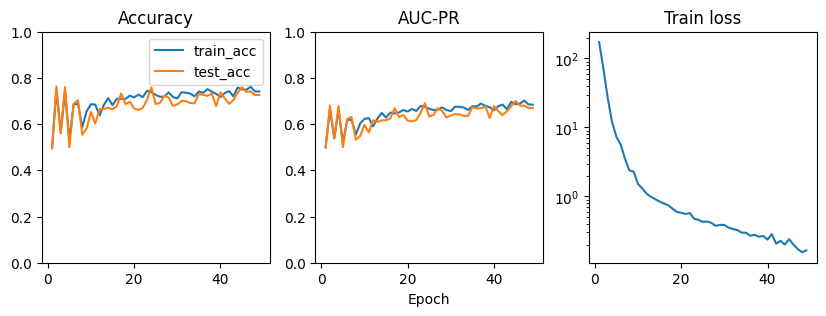

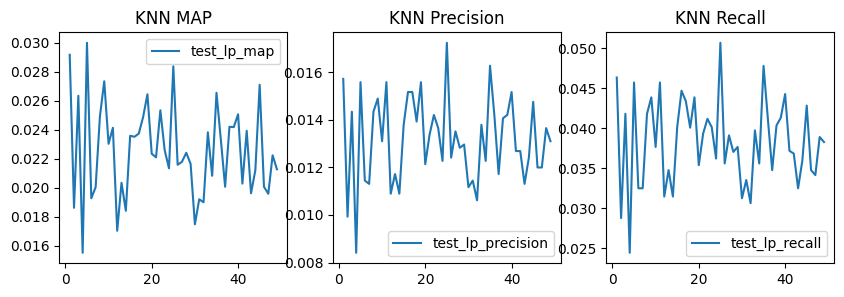

In [17]:
# plot training stats
stats_df = pd.DataFrame(stats)
stats_df.set_index('epoch', inplace=True)
# stats_df = stats_df[:58]

fig, axs = plt.subplots(1, 3)
fig.set_figwidth(10)
fig.set_figheight(3)

axs[0].plot(stats_df['train_acc'], label='train_acc')
axs[0].plot(stats_df['test_acc'], label='test_acc')
if VAL_FRACTION > 0:
    axs[0].plot(stats_df['val_acc'], label='val_acc')
axs[0].set_title('Accuracy')
axs[0].set_ylim(0, 1)
axs[0].legend()


axs[1].plot(stats_df['train_auc_pr'], label='train_auc_pr')
axs[1].plot(stats_df['test_auc_pr'], label='test_auc_pr')
if VAL_FRACTION > 0:
    axs[1].plot(stats_df['val_auc_pr'], label='val_auc_pr')
axs[1].set_ylim(0, 1)
axs[1].set_xlabel('Epoch')
axs[1].set_title('AUC-PR')

axs[2].plot(stats_df['train_loss'], label='train_loss')
axs[2].set_title('Train loss')
axs[2].set_yscale('log')

plt.show()

# plot test_lp stats
fig, axs = plt.subplots(1, 3)
fig.set_figwidth(10)
fig.set_figheight(3)

axs[0].plot(stats_df['test_lp_map'], label='test_lp_map')
axs[0].set_title('KNN MAP')
axs[0].legend()

axs[1].plot(stats_df['test_lp_precision'], label='test_lp_precision')
axs[1].set_title('KNN Precision')
axs[1].legend()

axs[2].plot(stats_df['test_lp_recall'], label='test_lp_recall')
axs[2].set_title('KNN Recall')
axs[2].legend()



In [45]:
# Run predictions

@torch.no_grad()
def run_top_k_lp_predictions(
    model,
    data,
    mappings,
    k,
):
    clear_cuda_mem()
    data.to(device)
    dst_emb = model.encoder(data.x_dict, data.edge_index_dict)['TargetTaxon']

    # Instantiate k-NN index based on maximum inner product search (MIPS):
    mips = MIPSKNNIndex(dst_emb)

    # Initialize metrics:
    map_metric = LinkPredMAP(k=k).to(device)
    precision_metric = LinkPredPrecision(k=k).to(device)
    recall_metric = LinkPredRecall(k=k).to(device)

    if 'edge_label_index' in data['Fasta', 'hasTaxOrder', 'TargetTaxon']:
        edge_label_index = data['Fasta', 'hasTaxOrder', 'TargetTaxon'].edge_label_index
    else:
        edge_label_index = data['Fasta', 'hasTaxOrder', 'TargetTaxon'].edge_index

    inv_fasta_mapping = {v: k for k, v in mappings['Fasta'].items()}
    inv_taxon_mapping = {v: k for k, v in mappings['TargetTaxon'].items()}

    data = data.to(device)
    emb = model.encoder(data.x_dict, data.edge_index_dict)['Fasta']

    for node_id in data['Fasta'].node_id:
        if node_id not in edge_label_index[0]:
            if node_id >= edge_label_index.shape[0]:
                emb = torch.cat([emb, emb[node_id].unsqueeze(0)], dim=0)
            else:
                emb = torch.cat([emb[:node_id], emb[node_id+1:]], dim=0)
        

    # Perform MIPS search:
    _, pred_index_mat = mips.search(emb, k)

    print(pred_index_mat.shape)
    print(edge_label_index.shape)

    map_metric.update(pred_index_mat, edge_label_index)
    precision_metric.update(pred_index_mat, edge_label_index)
    recall_metric.update(pred_index_mat, edge_label_index)

    pred_index_mat = pred_index_mat.cpu().numpy()
    edge_label_index = edge_label_index.cpu().numpy()

    taxon_nodes = get_filtered_taxon_nodes()

    rows = []
    for i, row in enumerate(pred_index_mat):
        try:
            fasta_node_id = edge_label_index[0][i]
            fasta_acc = inv_fasta_mapping[fasta_node_id]
            taxon_node_id = edge_label_index[1][i]
            tax_order = inv_taxon_mapping[taxon_node_id]
        except:
            continue
        
        true_tax_order_name = taxon_nodes.loc[
            taxon_nodes['taxId'] == tax_order
        ]['taxOrder'].values[0]
        
        pred_tax_orders = []
        for j in row:
            pred_tax_orders.append(inv_taxon_mapping[j])
        
        rows.append({
            'fasta': fasta_acc,
            'pred_tax_orders': pred_tax_orders,
            'true_tax_order': tax_order,
            'true_tax_order_name': true_tax_order_name,
            'correct': tax_order in pred_tax_orders
        })
    df = pd.DataFrame(rows)

    stats = {
        'map': float(map_metric.compute()),
        'precision': float(precision_metric.compute()),
        'recall': float(recall_metric.compute()),
    }
    return (
        df,
        stats
    )


@torch.no_grad()
def run_exhaustive_lp_predictions(
    model,
    data,
    mappings,
    threshold=0.5,
):
    # https://github.com/pyg-team/pytorch_geometric/discussions/6792
    file_path = DATASET_DIR + 'lp_pyg_preds.csv'

    pangenome_df = pd.read_csv(DATASET_DIR + 'pangenome_nodes.csv')
    fasta_df = pangenome_df.loc[
        (pangenome_df['nodeLabels'] == 'Fasta') & 
        (pangenome_df['isSegmented'] == False)
    ]

    taxon_df = pd.read_csv(DATASET_DIR + 'taxon_nodes.csv')
    taxon_df = taxon_df.loc[
        (taxon_df['taxKingdom'] == 'Viruses') & 
        (taxon_df['rank'] == 'order')
    ]

    num_taxons = len(taxon_df)

    # Nested loop over sotus to taxons
    outs = []
    for index, row in fasta_df[['appId', 'nodeId', 'order']].iterrows():
        fasta_i = mappings['Fasta'][row['appId']]
        row = torch.tensor([fasta_i] * num_taxons)
        col = torch.arange(num_taxons)
        edge_label_index = torch.stack([row, col], dim=0)
        
        pred = model(
            data.x_dict,
            data.edge_index_dict,
            edge_label_index
        )
        #pred = pred.sigmoid().view(-1).long().cpu()
        pred = pred.clamp(min=0, max=1)
        pred = (pred>threshold).float()

        print(fasta_i)
        print(pred)

        # ground_truth = torch.zeros(num_taxons)
        # ground_truth[mappings['TargetTaxon'][row['order']]] = 1
        # print(ground_truth)

        # for pred in preds:            
        #     if pred > threshold:
        #         outs.append({
        #             'sourceNodeId': fasta_row['nodeId'],
        #             'sourceAppId': fasta_app_id,
        #             'targetNodeId': taxon_row['nodeId'],
        #             'targetAppId': taxon_row['appId'],
        #             'probability': pred,
        #         })
    # write preds to column
    # df = pd.DataFrame(outs)
    # df.to_csv(file_path, index=False)
    return df


# preds = run_exhaustive_lp_predictions(
#     model,
#     ref_data,
#     mappings=mappings,
#     threshold=0.2,
# )

results, stats = run_top_k_lp_predictions(model, ref_data, mappings, k=20)

print(stats)


torch.Size([6348, 20])
torch.Size([2, 6232])
{'map': 0.1367781013250351, 'precision': 0.0461408831179142, 'recall': 0.9228177070617676}


(4711, 5)
(1521, 5)
0.7559370988446726


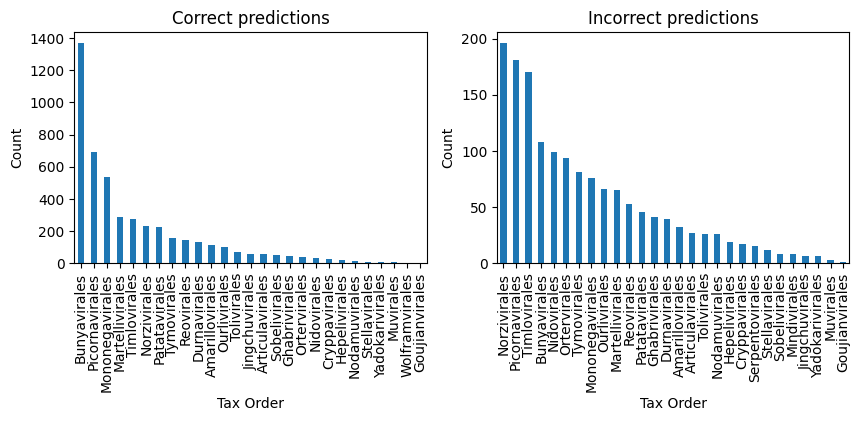

In [47]:
correct = results.loc[
    results['correct'] == True
]
incorrect = results.loc[
    results['correct'] == False
]
print(correct.shape)
print(incorrect.shape)
print(correct.shape[0] / (correct.shape[0] + incorrect.shape[0]))

correct_tax_order_counts = correct['true_tax_order_name'].value_counts()
incorrect_tax_order_counts = incorrect['true_tax_order_name'].value_counts()

fig, axs = plt.subplots(1, 2)
fig.set_figwidth(10)
fig.set_figheight(3)

correct_tax_order_counts.plot(kind='bar', ax=axs[0])
axs[0].set_title('Correct predictions')
axs[0].set_ylabel('Count')
axs[0].set_xlabel('Tax Order')

incorrect_tax_order_counts.plot(kind='bar', ax=axs[1])
axs[1].set_title('Incorrect predictions')
axs[1].set_ylabel('Count')
axs[1].set_xlabel('Tax Order')

plt.show()

In [ ]:
# Save or load model weights

def save_model(model):
    model_name = 'model_v1'
    weights_dir = f"{MODEL_DIR}{model_name}"
    if not os.path.exists(MODEL_DIR):
        os.makedirs(MODEL_DIR, exist_ok=True)
    torch.save(model.state_dict(), weights_dir)


def load_model(model_name='model_v1'):
    model = get_model_v1(ref_data)
    weights_dir = f"{MODEL_DIR}{model_name}/"
    model.load_state_dict(torch.load(weights_dir))
    return model


save_model(model)

In [40]:
import collections

# download pickle file
# if os.path.exists( DATASET_DIR + 'taxon_to_pfam.pkl'):

# HitRegion -> HitRegion
# HitRegion -> Hit
# Hit -> HitFamily
# map taxId to list of fasta accessions
# map taxId to list of sets of pfam accessions from HitFamily

taxon_to_fasta = collections.defaultdict(dict)
taxon_to_pfam = collections.defaultdict(set)

inv_hit_family_mapping = {v: k for k, v in mappings['HitFamily'].items()}

for _, row in merged_fasta_taxons.iterrows():
    # tax_id = row['taxId']
    tax_order = row['taxOrder']
    fasta_accession = row['sourceAppId']
    taxon_to_fasta[tax_order]['unique'] = []
    taxon_to_fasta[tax_order]['redundant'] = []

    print(tax_order)
    try: 
        fasta_node_id = mappings['Fasta'][fasta_accession]
    except KeyError:
        print(f'Fasta accession {fasta_accession} not found in mappings')
        continue

    # TODO: get ordered hits using hasNextDomain
    hit_node_ids = [] 
    for edge in data['Fasta', 'hasHit', 'Hit'].edge_index.T:
        if edge[0] == fasta_node_id:
            hit_node_ids.append(edge[1])
    
    hit_family_node_ids = []
    for hit_node_id in hit_node_ids:
        for edge in data['HitFamily', 'hasMember', 'Hit'].edge_index.T:
            if edge[1] == hit_node_id:
                hit_family_node_ids.append(edge[0])

    fasta_pfams = frozenset([
        inv_hit_family_mapping[hit_family_node_id.item()]
        if hit_family_node_id.item() in inv_hit_family_mapping
        else hit_family_node_id.item()
        for hit_family_node_id in hit_family_node_ids
    ])

    if fasta_pfams in taxon_to_pfam[tax_order]:
        taxon_to_fasta[tax_order]['redundant'].append(fasta_accession)
    else:
        taxon_to_pfam[tax_order].add(fasta_pfams)
        taxon_to_fasta[tax_order]['unique'].append(fasta_accession)


Ghabrivirales
Ghabrivirales
Ghabrivirales
Ghabrivirales
Ghabrivirales
Ghabrivirales
Ghabrivirales
Ghabrivirales
Ghabrivirales
Ghabrivirales
Ghabrivirales
Ghabrivirales
Ghabrivirales
Ghabrivirales
Ghabrivirales
Ghabrivirales
Ghabrivirales
Ghabrivirales
Ghabrivirales
Ghabrivirales
Ghabrivirales
Ghabrivirales
Ghabrivirales
Ghabrivirales
Ghabrivirales
Ghabrivirales
Ghabrivirales
Fasta accession MK584812 not found in mappings
Ghabrivirales
Fasta accession MF045841 not found in mappings
Ghabrivirales
Ghabrivirales
Ghabrivirales
Ghabrivirales
Ghabrivirales
Ghabrivirales
Ghabrivirales
Ghabrivirales
Ghabrivirales
Ghabrivirales
Ghabrivirales
Ghabrivirales
Ghabrivirales
Ghabrivirales
Ghabrivirales
Ghabrivirales
Ghabrivirales
Ghabrivirales
Ghabrivirales
Ghabrivirales
Ghabrivirales
Ghabrivirales
Ghabrivirales
Fasta accession MK584816 not found in mappings
Ghabrivirales
Ghabrivirales
Ghabrivirales
Ghabrivirales
Ghabrivirales
Ghabrivirales
Ghabrivirales
Ghabrivirales
Ghabrivirales
Ghabrivirales
Ghabr

In [ ]:
# store taxon_to_pfam as pickle
with open(DATASET_DIR + 'taxon_to_pfam.pkl', 'wb') as f:
    pickle.dump(taxon_to_pfam, f)

# store taxon_to_fasta as pickle
with open(DATASET_DIR + 'taxon_to_fasta.pkl', 'wb') as f:
    pickle.dump(taxon_to_fasta, f)


In [35]:
display(taxon_to_pfam)

defaultdict(list,
            {2732540: [{'PF00680',
               'PF00972',
               'PF00978',
               'PF00998',
               'PF02123',
               'PF03431',
               'PF04197',
               'PF05788',
               'PF05919',
               'PF09220'},
              {'PF00680',
               'PF00946',
               'PF00972',
               'PF00978',
               'PF00998',
               'PF02123',
               'PF03431',
               'PF04197',
               'PF05788',
               'PF05919',
               'PF07236'},
              {'PF00406',
               'PF00485',
               'PF00625',
               'PF01121',
               'PF01583',
               'PF01591',
               'PF01637',
               'PF01712',
               'PF01745',
               'PF02223',
               'PF02224',
               'PF02702',
               'PF03266',
               'PF03668',
               'PF03976',
               'PF05621',
         

In [ ]:
# plot distribution of lengths of taxon_to_pfam values
plot_data = {}
for tax_id, pfam_sets in taxon_to_pfam.items():
    plot_data[tax_id] = [len(pfam_set) for pfam_set in pfam_sets]

plot_df = pd.DataFrame(plot_data).T
plot_df.columns = ['Number of Pfam']
plot_df.plot(kind='bar')
plt.xlabel('Taxon Id')
plt.ylabel('Number of Pfam')
plt.show()


# plot jaccard index of pfam sets
jaccard_index = {}
for tax_id, pfam_sets in taxon_to_pfam.items():
    jaccard_index[tax_id] = []
    for i in range(len(pfam_sets)):
        for j in range(i+1, len(pfam_sets)):
            jaccard_index[tax_id].append(
                len(pfam_sets[i].intersection(pfam_sets[j])) / len(pfam_sets[i].union(pfam_sets[j])
            )

plot_df = pd.DataFrame(jaccard_index).T
plot_df.columns = ['Jaccard Index']
plot_df.plot(kind='bar')
plt.xlabel('Taxon Id')
plt.ylabel('Jaccard Index')
plt.show()


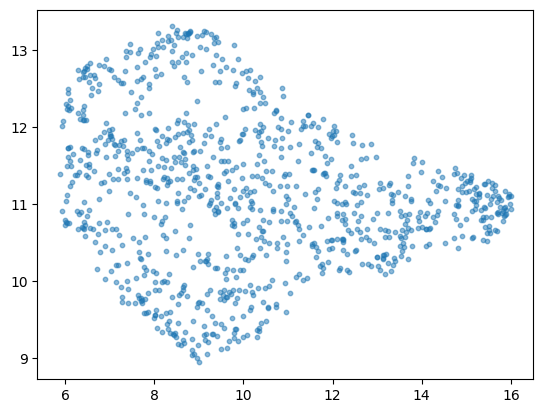

In [64]:
# UMAP plot

reducer = umap.UMAP()

train_data.to(device)

dst_emb = model.encoder(train_data.x_dict, train_data.edge_index_dict)['HitFamily']
dst_emb = dst_emb.cpu()
dst_emb = dst_emb.detach().numpy()

# taxon_nodes = pd.read_csv(DATASET_DIR + 'pfam_llm.csv')
# taxon_nodes = taxon_nodes.loc[
#     (taxon_nodes['taxKingdom'] == 'Viruses') & 
#     (taxon_nodes['rank'] == 'order')
# ]
# dst_emb = taxon_nodes['embeddings'].values
# dst_emb = [ast.literal_eval(i) for i in dst_emb]


# dst_emb = test_data['HitFamily'].x.cpu().numpy()
# dst_emb = train_data['Fasta'].x.cpu().numpy()

umap_emb = reducer.fit_transform(dst_emb)

plt.scatter(
    umap_emb[:, 0],
    umap_emb[:, 1],
    s=10,
    alpha=0.5,
)

In [ ]:
# Explainer

from torch_geometric.explain import CaptumExplainer, Explainer

# https://github.com/pyg-team/pytorch_geometric/blob/master/examples/explain/captum_explainer_hetero_link.py
explainer = Explainer(
    model=model,
    algorithm=CaptumExplainer('IntegratedGradients'),
    explanation_type='model',
    model_config=dict(
        mode='regression',
        task_level='edge',
        return_type='raw',
    ),
    node_mask_type='attributes',
    edge_mask_type='object',
    threshold_config=dict(
        threshold_type='topk',
        value=200,
    ),
)

index = torch.tensor([2, 10])  # Explain edge labels with index 2 and 10.
explanation = explainer(
    data.x_dict,
    data.edge_index_dict,
    index=index,
    edge_label_index=data['user', 'movie'].edge_label_index,
)
print(f'Generated explanations in {explanation.available_explanations}')

path = 'feature_importance.png'
explanation.visualize_feature_importance(top_k=10)

In [ ]:
# Plot networkx (todo)

from torch_geometric.utils import to_networkx, k_hop_subgraph
from torch_geometric.data import Data

# Convert to networkx graph
ref_data_homogenous = ref_data.to_homogeneous()
subset, edge_index, mapping, edge_mask = k_hop_subgraph(10, 1, ref_data_homogenous.edge_index)
print(ref_data_homogenous)
print(subset)
subgraph = Data(
    x=ref_data_homogenous.x[subset],
    node_id=subset,
    edge_index=edge_index,
    edge_label=ref_data_homogenous.edge_label[edge_mask],
    edge_type=ref_data_homogenous.edge_type[edge_mask],
)
print(subgraph)
subgraph = to_networkx(subgraph)

# # Plot networkx graph
nx.draw(subgraph, with_labels=True)
plt.show()


40017

## Traditional topological link prediction

In [ ]:
loader = get_train_loader(train_data, batch_size=100)

for batch in loader:
    batch_homogenous = batch.to_homogeneous()
    # print(batch_homogenous['edge_index'])
    print(batch_homogenous['edge_label'])

# print(len(loader))

In [ ]:
taxon_mapping = {v: k for k, v in mappings['TaxonOrder'].items()}
print(len(taxon_mapping))

In [ ]:
loader = get_train_loader(train_data, batch_size=2048)

fasta_mapping = {v: k for k, v in mappings['Fasta'].items()}
taxon_mapping = {v: k for k, v in mappings['TaxonOrder'].items()}
fts = []

for batch in loader:
    batch_homogenous = batch.to_homogeneous()
    G = to_networkx(batch_homogenous).to_undirected()

    G_connected = G.copy()
    isolated_nodes = [node for node in G.nodes() if G.degree(node) == 0]
    [G_connected.remove_node(i_n) for i_n in isolated_nodes]

    edge_index = batch_homogenous['edge_index'].tolist()
    ebunch = list(zip(edge_index[0], edge_index[1]))
    lp_iters = [
        # ('jaccard_coefficient',
        #  lambda: nx.jaccard_coefficient(G, ebunch)),
        ('preferential_attachment',
            lambda: nx.preferential_attachment(G, ebunch)),
        # ('adamic_adar_index',
        #  lambda: nx.adamic_adar_index(G_connected, ebunch)),
        # ('resource_allocation_index',
        #  lambda: nx.resource_allocation_index(G, ebunch)),
        # ('common_neighbor_centrality',
        #  lambda: nx.common_neighbor_centrality(G, ebunch)),
    ]
    fts_batch = []

    for alg_name, get_iter in lp_iters:
        iterable = get_iter()
        print(alg_name)
        for i, val in enumerate(iterable):
            # Handle Adamic Adar division by 0 edge case
            if i > len(batch_homogenous['edge_label']) - 1 or torch.isnan(
                    batch_homogenous['edge_label'][i]):
                print('herex')
                if len(fts_batch) > i:
                    fts_batch[i][alg_name] = 0
                continue

            if len(fts_batch) == 0:
                print('reset')

            if len(fts_batch) != i:
                print('here4')
                print(len(fts_batch), i)

            if len(fts_batch) == i:
                fts_batch.append({
                    'sourceAppId': fasta_mapping[val[0]],
                    'targetAppId': taxon_mapping[val[1]],
                    'actual': batch_homogenous[
                        'edge_label'][i].long().numpy(),
                })
            cur_row = fts_batch[i]
            cur_row[alg_name] = val[2]
    fts.extend(fts_batch)
x = pd.DataFrame(fts)

In [ ]:
def nx_run_link_pred(loader, mappings):
    fasta_mapping = {v: k for k, v in mappings['Fasta'].items()}
    taxon_mapping = {v: k for k, v in mappings['TaxonOrder'].items()}
    fts = []

    for batch in loader:
        print('here1')
        batch_homogenous = batch.to_homogeneous()
        G = to_networkx(batch_homogenous).to_undirected()
        print('here2')

        G_connected = G.copy()
        isolated_nodes = [node for node in G.nodes() if G.degree(node) == 0]
        [G_connected.remove_node(i_n) for i_n in isolated_nodes]

        edge_index = batch_homogenous['edge_index'].tolist()
        ebunch = list(zip(edge_index[0], edge_index[1]))
        lp_iters = [
            # ('jaccard_coefficient',
            #  lambda: nx.jaccard_coefficient(G, ebunch)),
            ('preferential_attachment',
             lambda: nx.preferential_attachment(G, ebunch)),
            # ('adamic_adar_index',
            #  lambda: nx.adamic_adar_index(G_connected, ebunch)),
            # ('resource_allocation_index',
            #  lambda: nx.resource_allocation_index(G, ebunch)),
            # ('common_neighbor_centrality',
            #  lambda: nx.common_neighbor_centrality(G, ebunch)),
        ]
        print('here3')
        fts_batch = []
        for alg_name, get_iter in lp_iters:
            iterable = get_iter()
            
            print(alg_name)
            for i, val in enumerate(iterable):
                # Handle Adamic Adar division by 0 edge case
                if i > len(batch_homogenous['edge_label']) - 1 or torch.isnan(
                        batch_homogenous['edge_label'][i]):
                    if len(fts_batch) > i:
                        fts_batch[i][alg_name] = 0
                    continue

                if len(fts_batch) == 0:
                    print('reset')

                if len(fts_batch) != i:
                    print('here4')
                    print(len(fts_batch), i)

                if len(fts_batch) == i:
                    fts_batch.append({
                        'sourceAppId': fasta_mapping[val[0]],
                        'targetAppId': taxon_mapping[val[1]],
                        'actual': batch_homogenous[
                            'edge_label'][i].long().numpy(),
                    })
                cur_row = fts_batch[i]
                cur_row[alg_name] = val[2]
        fts.extend(fts_batch)
    return pd.DataFrame(fts)


def nx_evaluate(ground_truths, preds):
    accuracy = accuracy_score(ground_truths, preds)
    precision = precision_score(ground_truths, preds)
    recall = recall_score(ground_truths, preds)
    f1 = f1_score(ground_truths, preds)
    roc_auc = roc_auc_score(ground_truths, preds)
    average_precision = average_precision_score(ground_truths, preds)
    metrics = ["accuracy", "precision", "recall",
               "f1", "roc_auc", "average_precision"]
    values = [accuracy, precision, recall, f1, roc_auc, average_precision]
    return pd.DataFrame(data={'metric': metrics, 'value': values})


def nx_evaluate_link_pred(fts):
    cols = [
        # 'jaccard_coefficient',
        'preferential_attachment',
        # 'adamic_adar_index',
        # 'resource_allocation_index',
        # 'common_neighbor_centrality',
    ]
    stats = []
    ground_truths = torch.tensor(fts['actual'].values.astype(int))
    ground_truths = ground_truths.clamp(min=0, max=1)
    for lp_alg in cols:
        preds = torch.tensor(fts[lp_alg].values.astype(float))
        # TODO: review if mid-point is best threshold for all algos
        threshold = torch.div(torch.min(preds) + torch.max(preds), 2)
        preds = (preds > threshold).clamp(min=0, max=1).long()
        stats.append(
            (lp_alg, evaluate(ground_truths, preds))
        )
    return stats

In [ ]:
# data, mappings = create_pyg_graph()
# train_data, val_data, test_data = split_data(data)
loader = get_train_loader(train_data)

lp_fts = nx_run_link_pred(loader, mappings)
stats = nx_evaluate_link_pred(lp_fts)

# 1002684
# 0
# 0 513704

## Plots